In [33]:
import os, re, operator, warnings, sys
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
from nltk.corpus import stopwords
from wordcloud import WordCloud
import gensim
from gensim.models import CoherenceModel,  LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim
from pprint import pprint
import string
import gensim
import numpy as np
import spacy

import warnings
warnings.filterwarnings('ignore')

### Task2: DS Component Building

#### MLops and components

Though manual model development practices following standard SDLC principles are common, only 20% to 40% of models reach production. **Mlops** brings the benefits we already know to the machine-learning and data science space. A Systems-oriented approach, MLops enables the integration of data science teams developing the models and ML-engineering teams responsible for deployment and maintenance in the production environment. Through CI/CD tools for automating infrastructure management and fast continuous development and testing, both teams will collaborate sharing responsibilities and avoiding “merge-hells” for better performance. Unique to Mlops is the addition of Models and Data as artifacts to be developed/version/served/evaluated/maintained to the Codebase running on top of the two following best practices from DevOps. Here both teams will share responsibilities and collaborate according to the best capability task fit.

The five components of Mlops **Training-operationalization** and **Continuous-training** on the development side and **Prediction-serving** and **Continuous-monitoring** on the deployment side plus **Data-and-model-management** acting as a bridge inbetween enable workflow automation and integration.

In [6]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Data Loading

In [7]:
# Initialize DataLoader
data_loader = SlackDataLoader(rpath+'/data/anonymized')

# Load data from a Slack channel
channels = data_loader.get_channels()
users = data_loader.get_users()
userNamesById, userIdsByName = data_loader.get_user_map()
channelNamesById, channelIdsByName = data_loader.get_channel_map()
all_channels_slack_data = {}
all_channels_slack_reactions = {}
for channel in channels:
    ch_path = rpath+'/data/anonymized/'+channel["name"]+'/'
    all_channels_slack_reactions[channel["id"]] = data_loader.parse_slack_reaction(ch_path, channel["name"])
    all_channels_slack_data[channel["id"]] = data_loader.slack_parser(ch_path)

### 1) What is the distribution of time differences between messages, replies, reactions, and any type event (message, reply, reaction)?

In [74]:
sample_channel_msg = all_channels_slack_data[channelIdsByName["all-community-building"]]
all_msg_ts = []
all_rpl_ts = []
for ch_id, ch_data in all_channels_slack_data.items():
    all_msg_ts.append(ch_data['msg_sent_time'])
    all_rpl_ts.append(ch_data['time_thread_start'])
#flatten
flat_all_msg_ts = [item/86400 for sublist in all_msg_ts for item in sublist]
flat_all_rpl_ts = [item/86400 for sublist in all_rpl_ts for item in sublist]
#sort
flat_all_msg_ts.sort()
flat_all_rpl_ts.sort()
#drope the first zeros(the msgs without replies)
flat_all_rpl_ts = flat_all_rpl_ts[next((i for i, x in enumerate(flat_all_rpl_ts) if x), None):]

In [75]:
sample_channel_msg.keys()

Index(['msg_type', 'msg_content', 'sender_name', 'msg_sent_time',
       'msg_dist_type', 'time_thread_start', 'reply_count',
       'reply_users_count', 'reply_users', 'tm_thread_end', 'channel'],
      dtype='object')

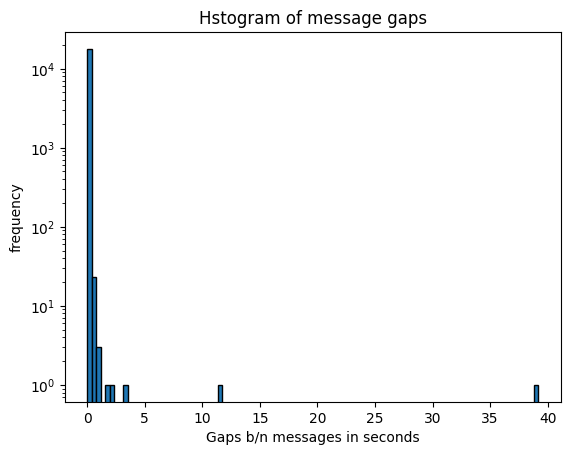

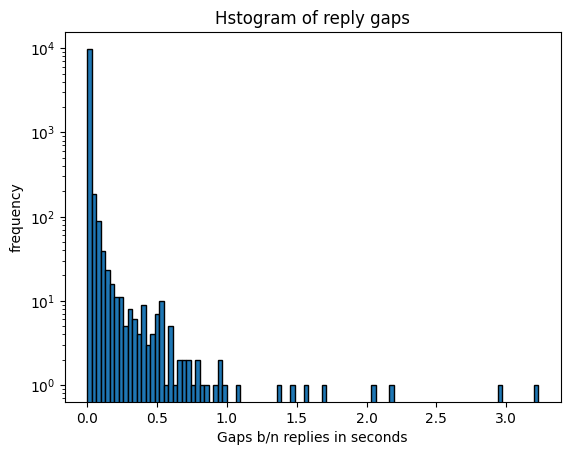

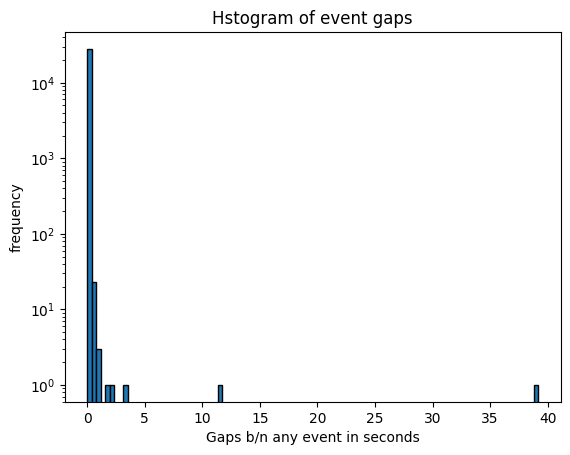

In [72]:
#Plot a histogram of the time difference between Consecutive messages
msg_gaps = [flat_all_msg_ts[i + 1] - flat_all_msg_ts[i] for i in range(len(flat_all_msg_ts)-1)]
plt.hist(msg_gaps, bins=100, edgecolor='black')
plt.yscale("log")
plt.xlabel('Gaps b/n messages in seconds')
plt.ylabel('frequency')
plt.title("Hstogram of message gaps")
plt.show()
#Plot a histogram of the time difference between Consecutive replies
rpl_gaps = [flat_all_rpl_ts[i + 1] - flat_all_rpl_ts[i] for i in range(len(flat_all_rpl_ts)-1)]
plt.hist(rpl_gaps, bins=100, edgecolor='black')
plt.yscale("log")
plt.xlabel('Gaps b/n replies in seconds')
plt.ylabel('frequency')
plt.title("Hstogram of reply gaps")
plt.show()
#Plot a histogram of the time difference between Consecutive reactions
#timestam of rection missing in the dataset

#Plot a histogram of the time difference between Consecutive events (message, reply, reaction)
#merge the msg and rpl time stamsps
all_ts = flat_all_msg_ts + flat_all_rpl_ts
all_ts.sort()
all_gaps = [all_ts[i + 1] - all_ts[i] for i in range(len(all_ts)-1)]
plt.hist(all_gaps, bins=100, edgecolor='black')
plt.yscale("log")
plt.xlabel('Gaps b/n any event in seconds')
plt.ylabel('frequency')
plt.title("Hstogram of event gaps")
plt.show()


### 2) Create ML models for message classification, topic modelling, and sentiment analysis and answer the following question

#### What are the top 10 topics of the different channels?

In [54]:
#collect the mesage texts for each channel
all_msg_txt = {}
for ch_id, ch_data in all_channels_slack_data.items():
    if len(ch_data['msg_content']):
        all_msg_txt[ch_id] = ' \n '.join(ch_data['msg_content'])

In [55]:
print(all_msg_txt[channelIdsByName['all-community-building']])

Morning boss 
 You can find the updated list of the hot seater's quake books <https://www.notion.so/Quake-books-1a622f5c9a1f4a418126fcc4ce05aa01|here>. Have fun reading. 
 *community Building Session REMINDER!*:timer_clock: *<!here>*
*Please note that CBS is on in the next 10min*
• *Session: My movie life*
• *Time*: From 12:00 PM - 12:30 PM UTC
• Platform: SLACK
 
 Hello 
 Selam 
 Helllllllllllllllllllllllllo My People 
 Hello 
 I am just here now, ask me anything about my trip to Ethiopia  yesterday 
 Hi 
 Hello 
 Welcome back to your place <@U03V1AM5TFA> 
 ሀይ ሀይ 
 I just realized that, i can't sleep without delivering a CBS, i didn't sleep last night:grinning: 
 hsdkfh.suovsfjkbadjkb 
 :grinning: 
 hey 
 hello 
 Who can guess what was yesterday's CBS thou 
 welcome back <@U03V1AM5TFA> we miss you 
 I see you still haven't learned from yesterday lol 
 well come back 
 Next time he will face a keyboard issue 
 we miss you too 
 Hello 
 :pray: 
 Probably...high and low! 
 He gonna lose 

#### A) Preprocessing

In [53]:
#spacy english corpus for training
nlp = spacy.load("en_core_web_sm")
all_doc = {}
for ch_id, msg_txt in all_msg_txt.items():
    all_doc[ch_id] = nlp(msg_txt)

KeyboardInterrupt: 

In [49]:
print(all_doc[channelIdsByName['all-community-building']])

Morning boss 
 You can find the updated list of the hot seater's quake books <https://www.notion.so/Quake-books-1a622f5c9a1f4a418126fcc4ce05aa01|here>. Have fun reading. 
 *community Building Session REMINDER!*:timer_clock: *<!here>*
*Please note that CBS is on in the next 10min*
• *Session: My movie life*
• *Time*: From 12:00 PM - 12:30 PM UTC
• Platform: SLACK
 
 Hello 
 Selam 
 Helllllllllllllllllllllllllo My People 
 Hello 
 I am just here now, ask me anything about my trip to Ethiopia  yesterday 
 Hi 
 Hello 
 Welcome back to your place <@U03V1AM5TFA> 
 ሀይ ሀይ 
 I just realized that, i can't sleep without delivering a CBS, i didn't sleep last night:grinning: 
 hsdkfh.suovsfjkbadjkb 
 :grinning: 
 hey 
 hello 
 Who can guess what was yesterday's CBS thou 
 welcome back <@U03V1AM5TFA> we miss you 
 I see you still haven't learned from yesterday lol 
 well come back 
 Next time he will face a keyboard issue 
 we miss you too 
 Hello 
 :pray: 
 Probably...high and low! 
 He gonna lose 

In [45]:
# We add some words to the stop word list
all_dictionary = OrderedDict()
all_corpus = OrderedDict()
article , texts = [],[]
for ch_id, doc in all_doc.items():
    for word in doc:
        if word.text != '\n' and not word.is_stop and not word.is_punct and not word.like_num and word.text != 'I':
            article.append(word.lemma_)
        if word.text == '\n':
            texts.append(article)
            article = []

    #compound words
    bigram = gensim.models.phrases.Phrases(texts)
    texts = [bigram[line] for line in texts]
    
    print(len(texts))
    #dictionaty and enumerated curpus
    if 
    all_dictionary['ch_id'] = Dictionary(texts)
    all_corpus['ch_id'] = [all_dictionary['ch_id'].doc2bow(text) for text in texts]
    texts = []

1104
3
185
245
64
41
71
895
0
26
73
0
71
10
61
116
7
5
18
47
0
138
42
40
115
13
17
15
12
6
95
71
6
0
0
19
0
0
0


#### LDA, or Latent Dirchlet Allocation is arguably the most famous topic modeling algorithm out there. Out here we create a simple topic model with 10 topics.

In [46]:
for ch_id, corpus, dictionary in zip(all_corpus.keys(), all_corpus.values(), all_dictionary.values()):
    lda_model = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)
    pyLDAvis.enable_notebook()
    pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

ValueError: cannot compute LDA over an empty collection (no terms)

#### What is the sentiment of messages as a function of the number of days since the start of the training?

In [ ]:
assert len(dm_outline) > 100
### BEGIN HIDDEN TESTS
assert len(dm_outline) > 70
### END HIDDEN TESTS

#### Model Evaluation

### 3) Model versioning with MLFlow

In [ ]:
assert len(how_success) > 100
### BEGIN HIDDEN TESTS
assert len(how_success) > 80
### END HIDDEN TESTS